In [1]:
import numpy as np
import cv2
from PIL import Image

def color_transfer(source, target, clip=True, preserve_paper=True):
    source = cv2.cvtColor(source, cv2.COLOR_BGR2LAB).astype("float32")
    target = cv2.cvtColor(target, cv2.COLOR_BGR2LAB).astype("float32")

    # compute color statistics for the source and target images
    (lMeanSrc, lStdSrc, aMeanSrc, aStdSrc, bMeanSrc, bStdSrc) = image_stats(source)
    (lMeanTar, lStdTar, aMeanTar, aStdTar, bMeanTar, bStdTar) = image_stats(target)

    # subtract the means from the target image
    (l, a, b) = cv2.split(target)
    l -= lMeanTar
    a -= aMeanTar
    b -= bMeanTar

    if preserve_paper:
        # scale by the standard deviations using paper proposed factor
        l = (lStdTar / lStdSrc) * l
        a = (aStdTar / aStdSrc) * a
        b = (bStdTar / bStdSrc) * b
    else:
        # scale by the standard deviations using reciprocal of paper proposed factor
        l = (lStdSrc / lStdTar) * l
        a = (aStdSrc / aStdTar) * a
        b = (bStdSrc / bStdTar) * b

    # add in the source mean
    l += lMeanSrc
    a += aMeanSrc
    b += bMeanSrc

    # clip/scale the pixel intensities to [0, 255] if they fall
    # outside this range
    l = _scale_array(l, clip=clip)
    a = _scale_array(a, clip=clip)
    b = _scale_array(b, clip=clip)

    # merge the channels together and convert back to the RGB color
    # space, being sure to utilize the 8-bit unsigned integer data
    # type
    transfer = cv2.merge([l, a, b])
    transfer = cv2.cvtColor(transfer.astype("uint8"), cv2.COLOR_LAB2RGB)

    # return the color transferred image
    return transfer


def image_stats(image):
    (l, a, b) = cv2.split(image)
    (lMean, lStd) = (l.mean(), l.std())
    (aMean, aStd) = (a.mean(), a.std())
    (bMean, bStd) = (b.mean(), b.std())

    # return the color statistics
    return (lMean, lStd, aMean, aStd, bMean, bStd)


def _min_max_scale(arr, new_range=(0, 255)):
    mn = arr.min()
    mx = arr.max()

    # check if scaling needs to be done to be in new_range
    if mn < new_range[0] or mx > new_range[1]:
        # perform min-max scaling
        scaled = (new_range[1] - new_range[0]) * \
            (arr - mn) / (mx - mn) + new_range[0]
    else:
        # return array if already in range
        scaled = arr

    return scaled


def _scale_array(arr, clip=True):
    if clip:
        scaled = np.clip(arr, 0, 255)
    else:
        scale_range = (max([arr.min(), 0]), min([arr.max(), 255]))
        scaled = _min_max_scale(arr, new_range=scale_range)

    return scaled

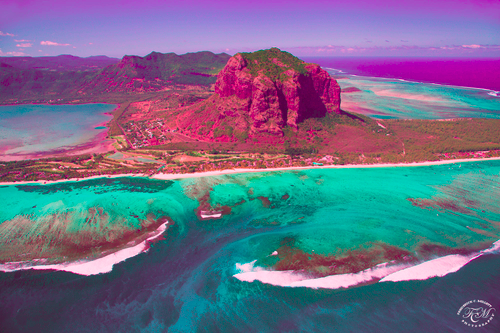

In [6]:
# load the images
source = cv2.imread("test3.jpg")
target = cv2.imread("test2.jpg")

source_flat = source.reshape(1,source.shape[0]*source.shape[1],3)
target_flat = target.reshape(1,target.shape[0]*target.shape[1],3)

# # transfer the color distribution from the source image
# # to the target image
transfer = color_transfer(source_flat, target_flat, clip="t", preserve_paper='t')
transfer = transfer.reshape(source.shape[0],source.shape[1],3)

img = Image.fromarray(transfer, 'RGB')
img